**Default Predictions to LendingClub Dataset**

# Introduction

The purpose of this project is to understand what makes a user default a loan from LendingClub. We will layout the most influencing parameters by considering both the statistical and lexicon based NLP modeling for the prediction. 

'Part I' deals with the EDA and traditional ML modeling with ANN. Following are the Algorithms that we've considered: 
1. Logistics Regression
2. Decision Tree
3. Random Forest
4. Support Vector Machines
5. Single Layered NN
6. Multi-Layered NN
7. Gradient Boosting
8. Bagging Classifier
9. Bagging Classiefier with Decision Tree Classifier
10. Voting Classifier
11. AdaBoost Classifier
12. Extra Tree Classifier

'Part II' is about the NLP approach to find Default predictions by using text data from the Dataset. 


Team Members: 
1. Pradeep Kumar Madakasira
2. Visarapu Jai Sai Manikanta
3. Kartikeya Madnani

*Disclaimer: We highly recommend you to open this file on Google Colab to use 'Table of Contents' as option for navigation *



# *PART I : Supervised ML Analysis*

# Importing Relevant Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import statsmodels.api as sm 
from sklearn.metrics import confusion_matrix

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

import keras
from keras.models import Sequential # sequential module reqd to initialize the NN
from keras.layers import Dense # dense module reqd to build the layers of the NN

import pickle 

#Apart from these packages, a few other have been imported when required. 

In [ ]:
## Reading the given dataset into 'data' dataframe. Please note the 'dependent variable' values are already assigned with 0's and 1's
data = pd.read_csv("/content/drive/My Drive/Projects/Dipyaman Project/fullacc.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,49,59,129,130,131,134,135,136,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
### In total, there are 150 columns with both continues and categorical variables. 
data.columns 

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=150)

In [ ]:
data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,...,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,3.342620e+05,0.0,334262.000000,334262.000000,334262.000000,334262.00000,334262.000000,3.342580e+05,334262.000000,334234.000000,334233.000000,334262.000000,334262.000000,334233.000000,151989.000000,42205.000000,334233.000000,334233.000000,3.342620e+05,334233.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334117.000000,63181.000000,334262.0,4.136000e+03,4136.000000,334233.000000,263986.000000,2.639860e+05,...,263986.000000,263986.000000,263986.000000,263986.000000,275672.000000,258092.000000,263986.000000,263986.000000,263986.000000,263833.000000,281351.000000,332897.000000,334157.000000,2.639860e+05,2.842320e+05,284232.000000,2.639860e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1189.0,1189.000000,1189.0,1189.000000,924.000000,1189.000000,1189.000000,4980.000000,4980.000000,4980.000000
mean,3.164503e+07,NaN,13875.948283,13840.409320,13744.993511,0.13816,425.222429,7.447377e+04,0.157044,0.001712,0.267212,698.371981,702.372070,0.762953,34.494523,74.883213,11.015507,0.150895,1.607664e+04,24.062056,529.126631,528.995478,14944.843258,14845.579036,11787.303418,2974.938506,1.598782,181.002558,24.858432,3968.100194,682.480058,668.680496,0.008548,42.982352,1.0,1.139798e+05,18.034579,0.003530,154.674051,1.402929e+05,...,8.079269,8.105384,14.432068,5.627988,11.307619,0.000678,0.002871,0.076731,1.930095,94.574750,49.559745,0.100112,0.031931,1.714015e+05,4.661599e+04,20963.748185,3.904553e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,158.134113,3.0,13.714045,454.083247,11501.755517,181.890538,4632.592337,47.011159,10.858233
std,4.114463e+07,NaN,8456.075067,8437.598651,8465.548267,0.04575,253.955017,6.245915e+04,0.363843,0.000909,0.775058,31.676947,31.677364,1.073888,21.782080,29.755241,5.035588,0.497684,2.075735e+04,11.432065,2320.875181,2320.584334,10351.531723,10367.476867,8216.350661,3224.871279,11.935766,838.080795,141.214422,5941.951128,79.300176,120.989880,0.103159,21.338562,0.0,5.359257e+04,6.830180,0.065177,2162.366510,1.563619e+05,...,6.967748,4.235378,7.637122,3.068014,5.082346,0.026909,0.057336,0.453984,1.687814,8.404424,35.394278,0.323046,0.312322,1.753001e+05,4.505938e+04,20121.399271,4.146716e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,132.157596,0.0,9.710402,374.560643,7764.558706,196.320385,3495.971759,7.844463,8.918410
min,5.473400e+04,NaN,500.000000,500.000000,0.000000,0.05320,4.930000,0.000000e+00,0.000000,0.000000,0.000000,610.000000,614.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,

### Data Pre-Processing

In [ ]:
## Checking to see all those fields with data more than '90%' available and only considering them.

check_na=(data.isna().mean().round(4) * 100)
i=0
f=0
na_list=[]

for k in check_na:
  if k > 10:
    #print(check_na.index[i])
    na_list.append(check_na.index[i])
    f = f+ 1
  i = i + 1

len(na_list) # This gives the number of such predictors which have data less than '90%' available. 

92

In [ ]:
list = data.columns
req = [i for i in list if i not in na_list] # These are the predictors which are above 90% filled and considered for the next process
print(req)

['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens', 'hardship_flag', 'debt_settlement_flag']


Variables rejected: 

1. 'funded_amnt', 'funded_amnt_inv' are directly related to loan_amnt, hence removing these. 

2. 'installment' is rejected as I chose to keep term value. 

2. 'grade', 'sub_grade', 'emp_title', 'url','title', 'zip_code' are not considered



In [ ]:
data_selected = data[['id', 'loan_amnt', 'term',  'emp_length', 'home_ownership', 'annual_inc', 
                      'verification_status','issue_d' , 'loan_status', 'pymnt_plan', 'purpose', 
                       'addr_state', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 
                      'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 
                      'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                      'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 
                      'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 
                      'tax_liens', 'hardship_flag', 'debt_settlement_flag']].copy()

In [ ]:
data_selected # In total, we are considering 45 columns

,id,loan_amnt,term,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,debt_settlement_flag
0,1077501,5000,36 months,10+ years,RENT,24000.0,Verified,Dec-11,0,n,credit_card,AZ,0.002765,0.0,735,739,1.0,3.0,0.0,13648,83.70%,9.0,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.0000,171.62,714,710,0.0,1,Individual,0.0,0.0,0.0,0.0,0.0,N,N
1,1077430,2500,60 months,< 1 year,RENT,30000.0,Source Verified,Dec-11,1,n,car,GA,0.000100,0.0,740,744,5.0,3.0,0.0,1687,9.40%,4.0,f,0.00,0.00,1014.530000,1014.53,456.46,435.17,0.00,122.90,1.1100,119.66,499,0,0.0,1,Individual,0.0,0.0,0.0,0.0,0.0,N,N
2,1077175,2400,36 months,10+ years,RENT,12252.0,Not Verified,Dec-11,0,n,small_business,IL,0.000872,0.0,735,739,2.0,2.0,0.0,2956,98.50%,10.0,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.0000,649.91,739,735,0.0,1,Individual,0.0,0.0,0.0,0.0,0.0,N,N
3,1076863,10000,36 months,10+ years,RENT,49200.0,Source Verified,Dec-11,0,n,other,CA,0.002000,0.0,690,694,1.0,10.0,0.0,5598,21%,37.0,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.0000,357.48,604,600,0.0,1,Individual,0.0,0.0,0.0,0.0,0.0,N,N
4,1075358,3000,60 months,1 year,RENT,80000.0,Source Verified,Dec-11,0,n,other,OR,0.001794,0.0,695,699,0.0,15.0,0.0,27783,53.90%,38.0,f,0.00,0.00,4066.908161,4066.91,3000.00,1066.91,0.00,0.00,0.0000,67.30,684,680,0.0,1,Individual,0.0,0.0,0.0,0.0,0.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334257,89885898,24000,60 months,7 years,MORTGAGE,95000.0,Source Verified,Oct-16,0,n,home_improvement,AL,0.001961,0.0,665,669,0.0,5.0,0.0,49431,84.40%,54.0,f,0.00,0.00,30444.213690,30444.21,24000.00,6444.21,0.00,0.00,0.0000,14140.21,719,715,0.0,1,Individual,0.0,0.0,0.0,0.0,0.0,N,N
334258,88977788,24000,60 months,10+ years,MORTGAGE,108000.0,Not Verified,Oct-16,0,n,debt_consolidation,UT,0.003494,0.0,695,699,1.0,24.0,1.0,21665,39%,58.0,f,12355.52,12355.52,17071.490000,17071.49,11644.48,5427.01,0.00,0.00,0.0000,515.74,739,735,0.0,1,Individual,0.0,0.0,0.0,0.0,1.0,N,N
334259,88985880,40000,60 months,9 years,MORTGAGE,227000.0,Verified,Oct-16,0,n,debt_consolidation,CA,0.001275,7.0,705,709,1.0,5.0,0.0,8633,64.90%,37.0,f,0.00,0.00,48369.405940,48369.41,40000.00,8369.41,0.00,0.00,0.0000,23465.48,719,715,0.0,1,Individual,0.0,0.0,0.0,0.0,0.0,N,N
334260,88224441,24000,60 months,6 years,RENT,110000.0,Not Verified,Oct-16,1,n,debt_consolidation,FL,0.001830,0.0,660,664,0.0,10.0,1.0,17641,68.10%,31.0,f,0.00,0.00,16190.840000,16190.84,3521.91,3233.49,0.00,9435.44,1698.3792,564.56,629,625,0.0,1,Individual,0.0,0.0,0.0,1.0,0.0,N,Y


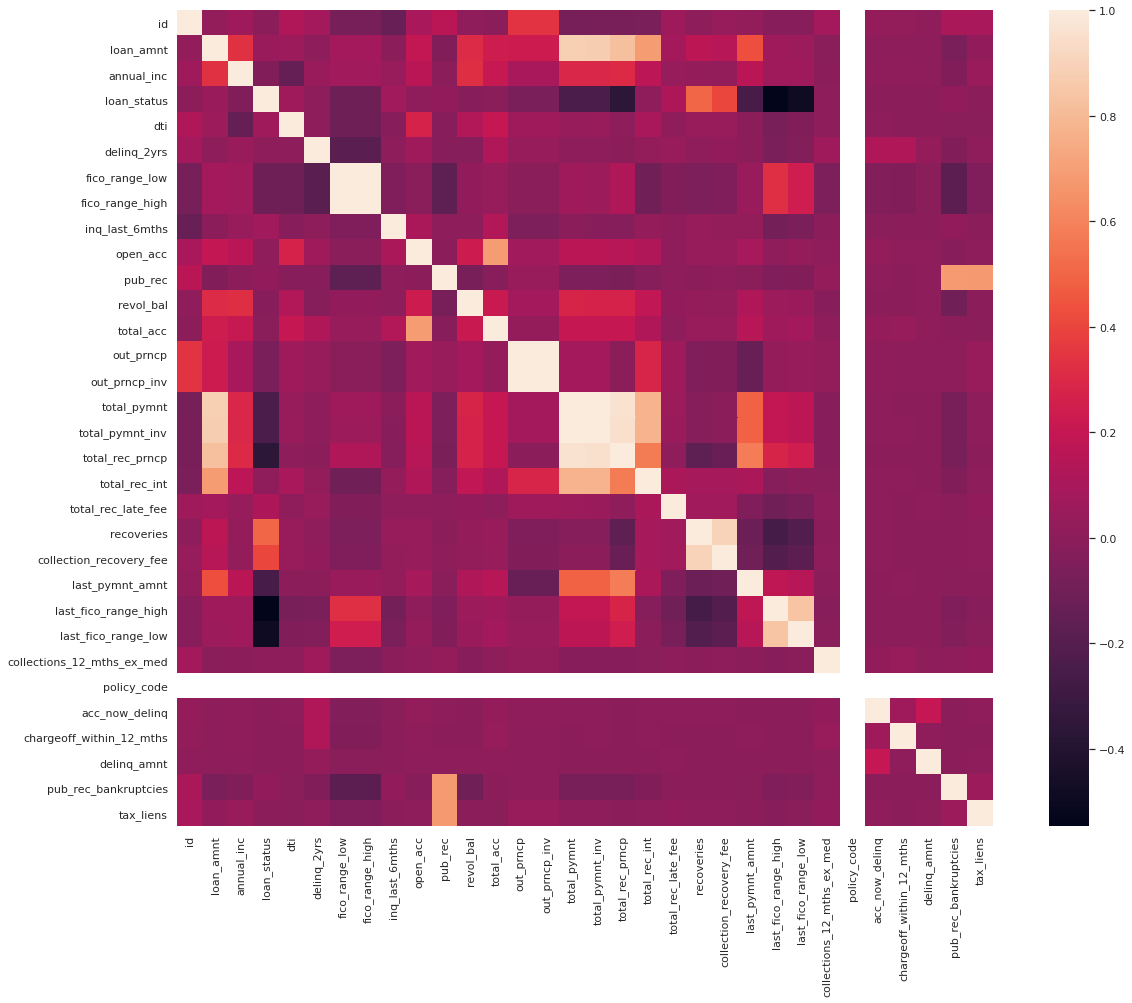

In [ ]:
#Correlation Heat Map
cor = data_selected.corr() 
plt.subplots(figsize=(20,15))
sns.heatmap(cor, square = True)

From the above heatmap removing variables with high correlation. Following are removed:

1. policy_code
2. fico_range_high
3. out_prncp_inv
4. 'total_pymnt_inv'
5. 'total_rec_prncp'
6. 'total_rec_int'
7. 'collection_recovery_fee'
8. 'last_fico_range_low'
9. 'total_pymnt'



Therefore, removing one of the variable from each cases.  


In [ ]:
data_selected.drop(['policy_code', 'fico_range_high', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                    'collection_recovery_fee','last_fico_range_low', 'total_pymnt', 'pub_rec_bankruptcies', 'tax_liens','open_acc',
                    'issue_d', 'revol_util'  ], axis=1, inplace = True)



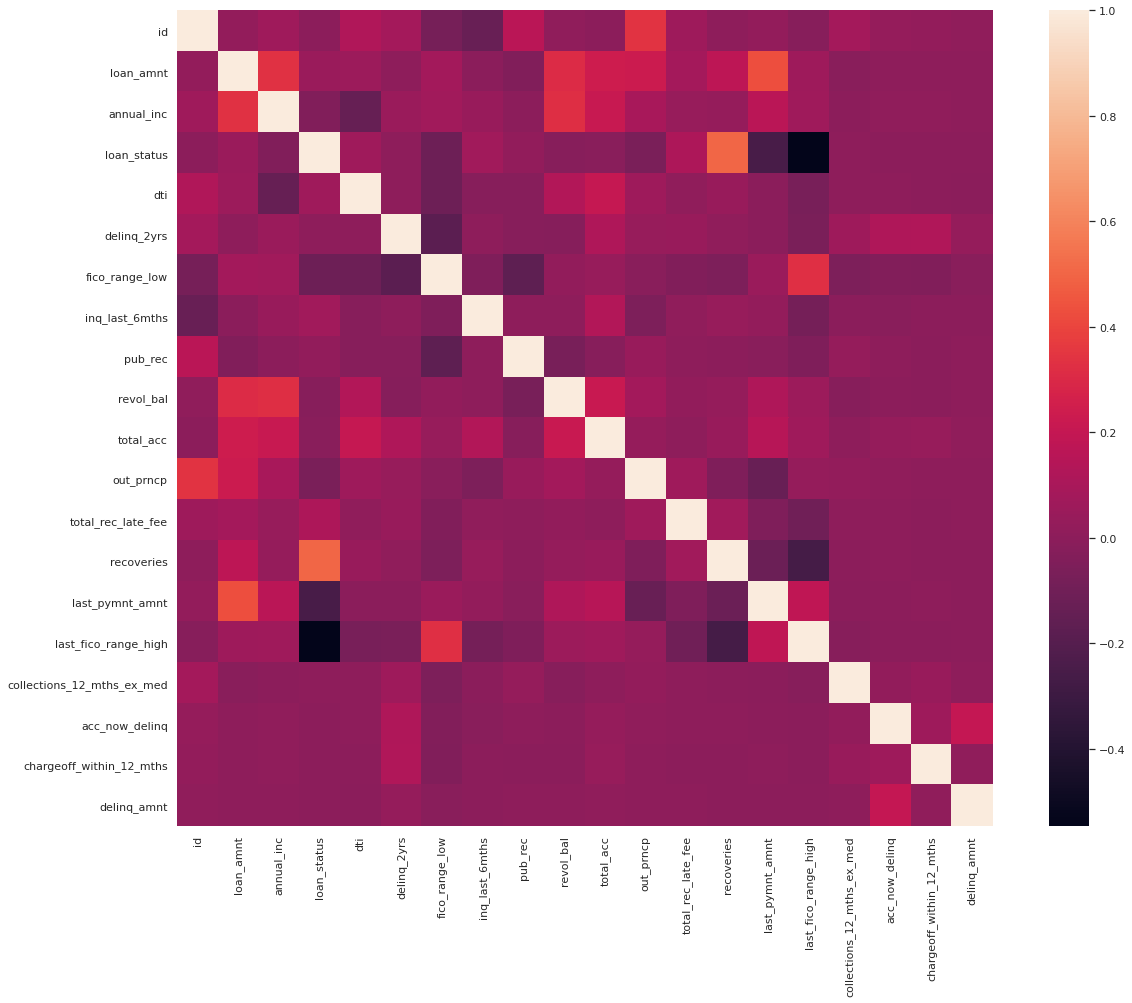

In [ ]:
#### Rechecking correlation 
import seaborn as sns
from matplotlib import pyplot as plt
cor = data_selected.corr() 
plt.subplots(figsize=(20,15))
sns.heatmap(cor, square = True)

### Exploratory Data Analysis (EDA)

In [ ]:
data_selected.info()
##Columns which have missing values are : emp_length, annual_inc, dti, delinq_2yrs, inq_last_6mths ,open_acc,pub_rec 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334262 entries, 0 to 334261
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          334262 non-null  int64  
 1   loan_amnt                   334262 non-null  int64  
 2   term                        334262 non-null  object 
 3   emp_length                  318386 non-null  object 
 4   home_ownership              334262 non-null  object 
 5   annual_inc                  334258 non-null  float64
 6   verification_status         334262 non-null  object 
 7   loan_status                 334262 non-null  int64  
 8   pymnt_plan                  334262 non-null  object 
 9   purpose                     334262 non-null  object 
 10  addr_state                  334262 non-null  object 
 11  dti                         334234 non-null  float64
 12  delinq_2yrs                 334233 non-null  float64
 13  fico_range_low

In [ ]:
#Dropping the NaN values from the fields selectd. However, please note that 'emp_length' is not considered here as NaN corrosponds to 'unemployeed' section of people
data_selected.dropna(subset=['loan_amnt', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 
 'pub_rec', 'revol_bal', 'total_acc', 
'out_prncp', 'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 
'last_fico_range_high', 'collections_12_mths_ex_med', 'acc_now_delinq', 
'chargeoff_within_12_mths', 'delinq_amnt'], inplace=True)


Documentation of a few of the predictors:

id -> A unique LC assigned ID for the loan listing.

loan_amnt -> The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

term -> The Number of payments on the loan. Values are in months and can be either 36 or 60.

emp_length ->Employment length in months. Possible values are whole numbers from 0 and higher. Null indicates not employed.

home_ownership -> The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER

annual_inc -> The annual income provided by the borrower during registration.

verification_status -> verfied by which mode

dti -> The borrower's debt to income ratio, calculated using the monthly payments on the total debt obligations, excluding mortgage, divided by self-reported monthly income.

delinq_2yrs -> The Number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

fico_range_low -> The lower boundary of range the borrower's FICO belongs to.

inqLast6Mths -> The Number of inquiries by creditors during the past 6 months.

openAcc - > The Number of open credit lines in the borrower's credit file.

pubRec -> Number of derogatory public records.



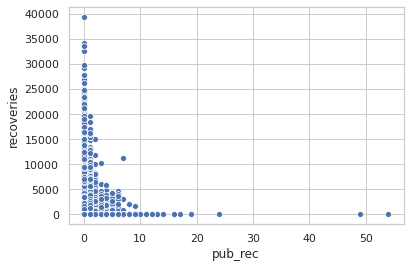

In [ ]:
# Shows the derogatory public records w.r.t recoveries. As one can understand, accounts which had a bad records do not pay(recoveries)
ax = sns.scatterplot(x="pub_rec", y="recoveries", data=data_selected)

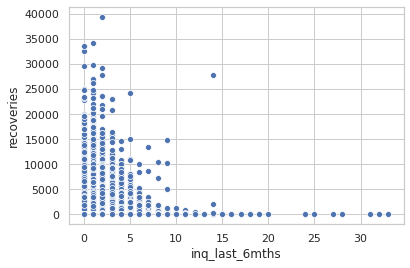

In [ ]:
ax = sns.scatterplot(x="inq_last_6mths", y="recoveries", data=data_selected)
#A lot of calls have been made by the creditors who have very low recovery numbers. 
#However, there is one outlier with recoveries between 25000 to 30000 and inquiries between 10 to 15, which can be seen below

In [ ]:
##Deleting the record with the outlier. 
i = 0
list=[]
for k in data_selected.inq_last_6mths:
  if 10<k<15 and data_selected.recoveries[i]>25000:
    print("deleted the row", i, "with value", data_selected.recoveries[i])
    data_selected.drop(index = i, inplace= True)
  i = i + 1

In [ ]:
#test = data_selected.groupby(['purpose'], axis=0).size()

#test.index

total = data_selected.groupby('purpose').size()
defaulted=data_selected.groupby(['loan_status', 'purpose'], axis=0).size()[14:]
new=defaulted/total
new

loan_status  purpose           
1            car                   0.111793
             credit_card           0.132297
             debt_consolidation    0.165707
             educational           0.211165
             home_improvement      0.136995
             house                 0.167253
             major_purchase        0.129873
             medical               0.161454
             moving                0.167625
             other                 0.172112
             renewable_energy      0.181538
             small_business        0.255423
             vacation              0.157772
             wedding               0.124197
dtype: float64

[Text(0, 0, 'car'),
 Text(0, 0, 'credit_card'),
 Text(0, 0, 'debt_consolidation'),
 Text(0, 0, 'educational'),
 Text(0, 0, 'home_improvement'),
 Text(0, 0, 'house'),
 Text(0, 0, 'major_purchase'),
 Text(0, 0, 'medical'),
 Text(0, 0, 'moving'),
 Text(0, 0, 'other'),
 Text(0, 0, 'renewable_energy'),
 Text(0, 0, 'small_business'),
 Text(0, 0, 'vacation'),
 Text(0, 0, 'wedding')]

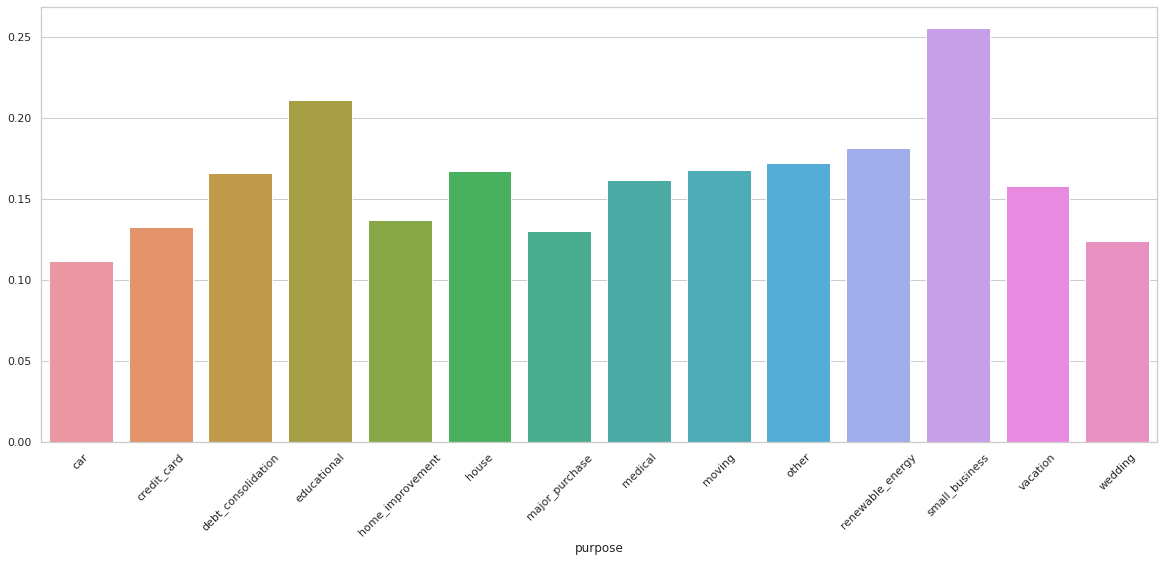

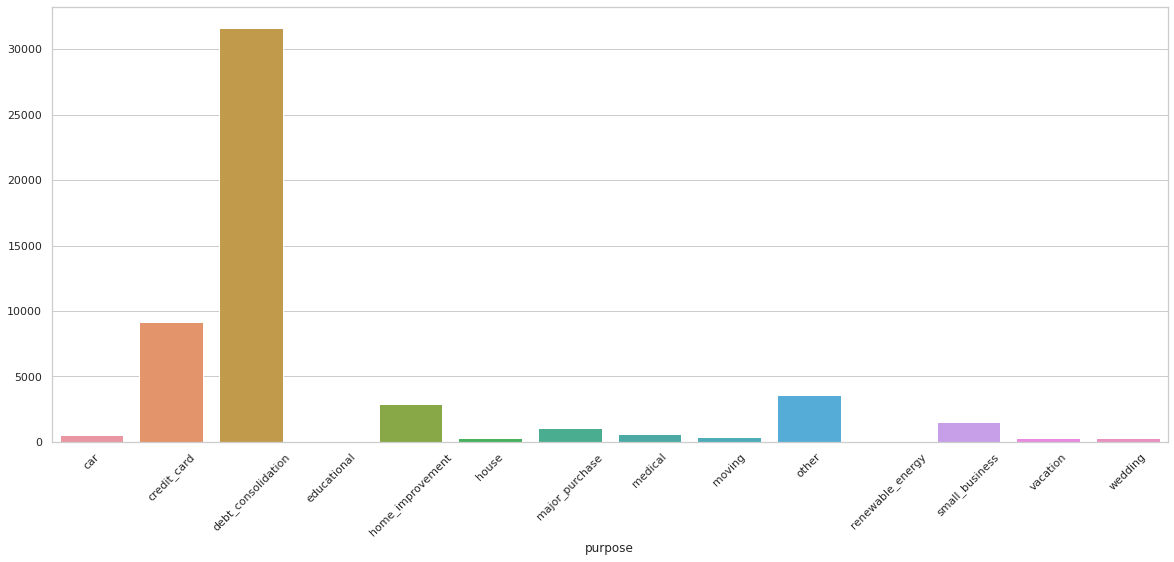

In [ ]:
plt.subplots(figsize=(20,8))
sns.set(style="whitegrid")
x=data_selected.groupby(['purpose'], axis=0).size().index
y1=new
ax = sns.barplot(x=x, y=y1, data=data_selected)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.subplots(figsize=(20,8))
sns.set(style="whitegrid")
x=data_selected.groupby(['purpose'], axis=0).size().index
y2=data_selected.groupby(['loan_status', 'purpose'], axis=0).size()[14:]
ax = sns.barplot(x=x, y=y2, data=data_selected)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

As you can infer from above chart, a lot of customers who default are from debt_consolidation category. However, a large percentage of detaults are from small business, followed by educational

In [ ]:
data_selected

,id,loan_amnt,term,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,fico_range_low,inq_last_6mths,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,total_rec_late_fee,recoveries,last_pymnt_amnt,last_fico_range_high,collections_12_mths_ex_med,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,hardship_flag,debt_settlement_flag
0,1077501,5000,36 months,10+ years,RENT,24000.0,Verified,0,n,credit_card,AZ,0.002765,0.0,735,1.0,0.0,13648,9.0,f,0.00,0.00,0.00,171.62,714,0.0,Individual,0.0,0.0,0.0,N,N
1,1077430,2500,60 months,< 1 year,RENT,30000.0,Source Verified,1,n,car,GA,0.000100,0.0,740,5.0,0.0,1687,4.0,f,0.00,0.00,122.90,119.66,499,0.0,Individual,0.0,0.0,0.0,N,N
2,1077175,2400,36 months,10+ years,RENT,12252.0,Not Verified,0,n,small_business,IL,0.000872,0.0,735,2.0,0.0,2956,10.0,f,0.00,0.00,0.00,649.91,739,0.0,Individual,0.0,0.0,0.0,N,N
3,1076863,10000,36 months,10+ years,RENT,49200.0,Source Verified,0,n,other,CA,0.002000,0.0,690,1.0,0.0,5598,37.0,f,0.00,16.97,0.00,357.48,604,0.0,Individual,0.0,0.0,0.0,N,N
4,1075358,3000,60 months,1 year,RENT,80000.0,Source Verified,0,n,other,OR,0.001794,0.0,695,0.0,0.0,27783,38.0,f,0.00,0.00,0.00,67.30,684,0.0,Individual,0.0,0.0,0.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334257,89885898,24000,60 months,7 years,MORTGAGE,95000.0,Source Verified,0,n,home_improvement,AL,0.001961,0.0,665,0.0,0.0,49431,54.0,f,0.00,0.00,0.00,14140.21,719,0.0,Individual,0.0,0.0,0.0,N,N
334258,88977788,24000,60 months,10+ years,MORTGAGE,108000.0,Not Verified,0,n,debt_consolidation,UT,0.003494,0.0,695,1.0,1.0,21665,58.0,f,12355.52,0.00,0.00,515.74,739,0.0,Individual,0.0,0.0,0.0,N,N
334259,88985880,40000,60 months,9 years,MORTGAGE,227000.0,Verified,0,n,debt_consolidation,CA,0.001275,7.0,705,1.0,0.0,8633,37.0,f,0.00,0.00,0.00,23465.48,719,0.0,Individual,0.0,0.0,0.0,N,N
334260,88224441,24000,60 months,6 years,RENT,110000.0,Not Verified,1,n,debt_consolidation,FL,0.001830,0.0,660,0.0,1.0,17641,31.0,f,0.00,0.00,9435.44,564.56,629,0.0,Individual,0.0,0.0,0.0,N,Y


Important to note that employee_length with null values are 'unemployeed' and should not be removed. 
Removing entries with no values for annual income, dti, delinq_2yrs, inq_last_6mths, open_acc, pub_rec (please note that the last 3 have no values to the same records). 

Visualizing Categorical information: 

In [ ]:
print(data_selected.groupby('loan_status').size()) #Checking counts of 0's and 1's in target variable

loan_status
0    281627
1     52462
dtype: int64


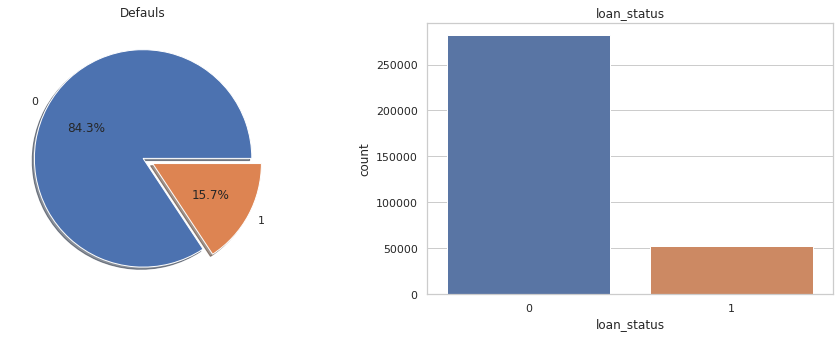

In [ ]:
#Pictorial representation of imbalenced nature of target variable. We will have to employee sampling techniques to minimise this imbalance.
#We've chosen Up-Sampling technique here. 

f,ax=plt.subplots(1,2,figsize=(16,5))
data_selected['loan_status'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Defauls')
ax[0].set_ylabel('')
sns.countplot('loan_status',data=data_selected,ax=ax[1])
ax[1].set_title('loan_status')
plt.show()

Upsampling

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3717: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


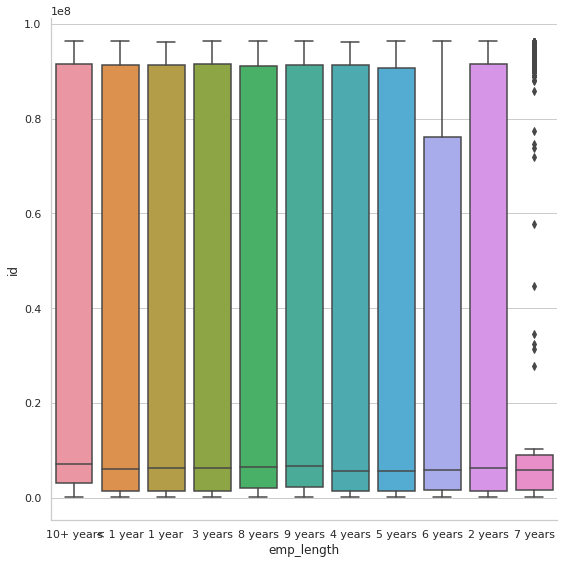

In [ ]:
sns.catplot(x="emp_length", y="id", kind="box",ax=ax, height= 8, aspect=1 ,data=data_selected)

#we can see a lot of values like outside the majority region for '7 years'. This will be treated by dropping while avoiding dummy variable trap. 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3717: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


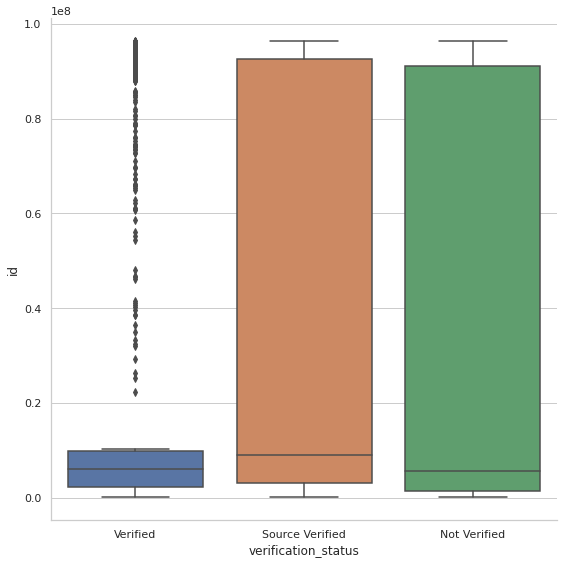

In [ ]:
sns.catplot(x="verification_status", y="id", kind="box",ax=ax, height= 8, aspect=1 ,data=data_selected)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3717: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


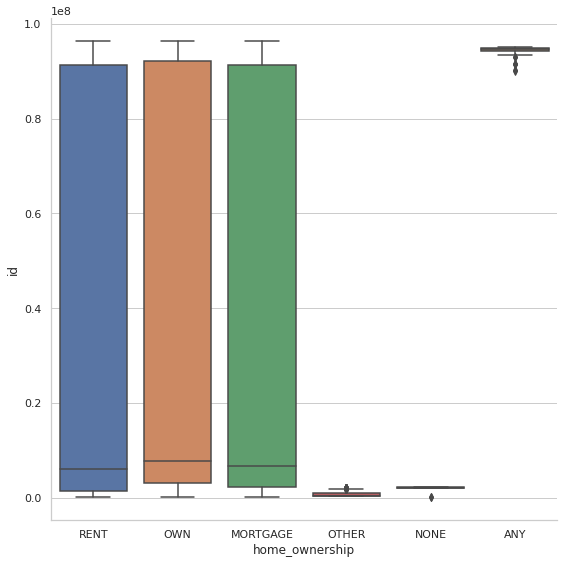

In [ ]:
sns.catplot(x="home_ownership", y="id", kind="box",ax=ax, height= 8, aspect=1 ,data=data_selected)

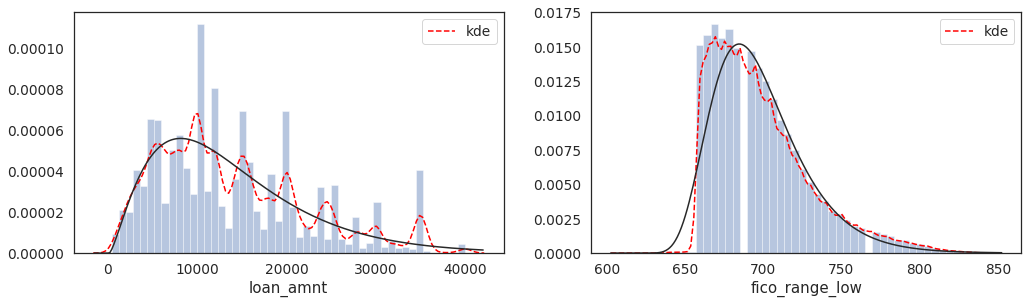

In [ ]:
from scipy import stats
sns.set_style("white")
fig, axs = plt.subplots(1,2, figsize=(15,5))
fig.tight_layout(pad=3.0)
sns.distplot(data_selected['loan_amnt'],fit=stats.gamma,kde=True, kde_kws={"color":"red", "label":"kde",'linestyle':'--'}, ax=axs[0])
sns.distplot(data_selected['fico_range_low'],fit=stats.lognorm,kde=True,kde_kws={"color":"red", "label":"kde",'linestyle':'--'},ax=axs[1])

1. We can see most of the loan amounts are in between 4000 to 12000. 
2. The dirtibution of fico range low is normally distributed




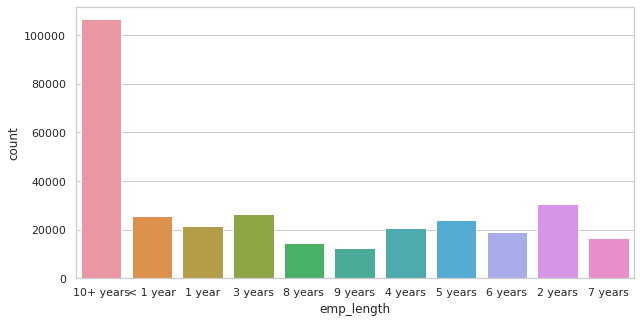

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data_selected['emp_length'])
plt.show()

1. We can clearly say that most of the employees who are taking loan amount are having 10+ years of work experience
2. After the 10+ years of experience people most of the customers who are taking loans are less than 5 years of experience.

In [ ]:
categorical = ['home_ownership','pymnt_plan','purpose','emp_length']

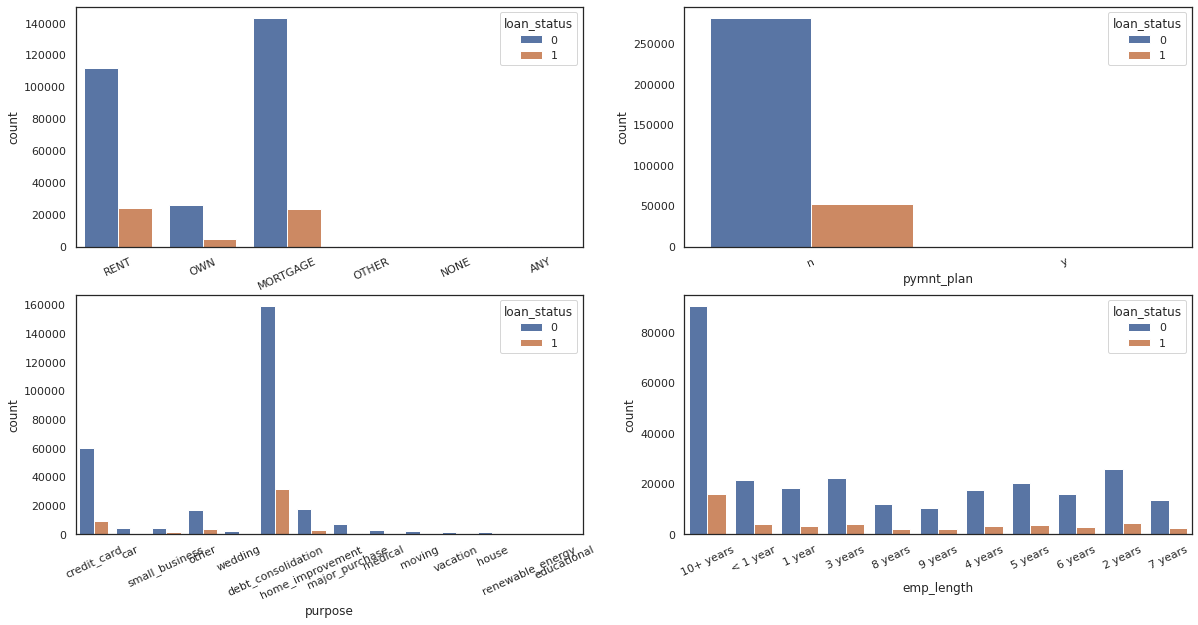

In [ ]:
sns.set_style("white")
fig = plt.figure(figsize = (20,15))
axes = 320
for cat in categorical:
    axes += 1
    fig.add_subplot(axes)
    sns.countplot(data =data_selected , x = cat, hue='loan_status')
    plt.xticks(rotation=25)
plt.show()



1.   Customers who are belonged to Mortgage category are taking most loan amounts because of that default customers are alos high in Mortgage ownership
2.   Most of the customers do not have the payment plan
3. Most of the customers are taking up loans because of the wedding purpose. So even default percentage is high in this category of loan
4. Default percentage is high in the customers who are having less than 5 years of work experience. so be cautious while giving loans to those category of customers



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


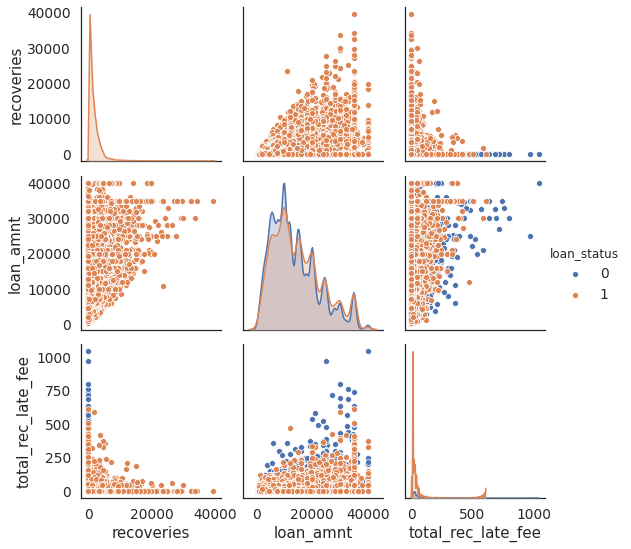

In [ ]:
colors = ["#a1d76a","#dd1c77"]
# Set your custom color palette
sns.set_palette(colors)
sns.set(font_scale=1.25)
sns.set_style("white")
sns.pairplot(data_selected, vars = ['recoveries', 'loan_amnt', 'total_rec_late_fee'], hue = 'loan_status')



Text(0.5, 1.0, 'Loan Amount by home_ownership')

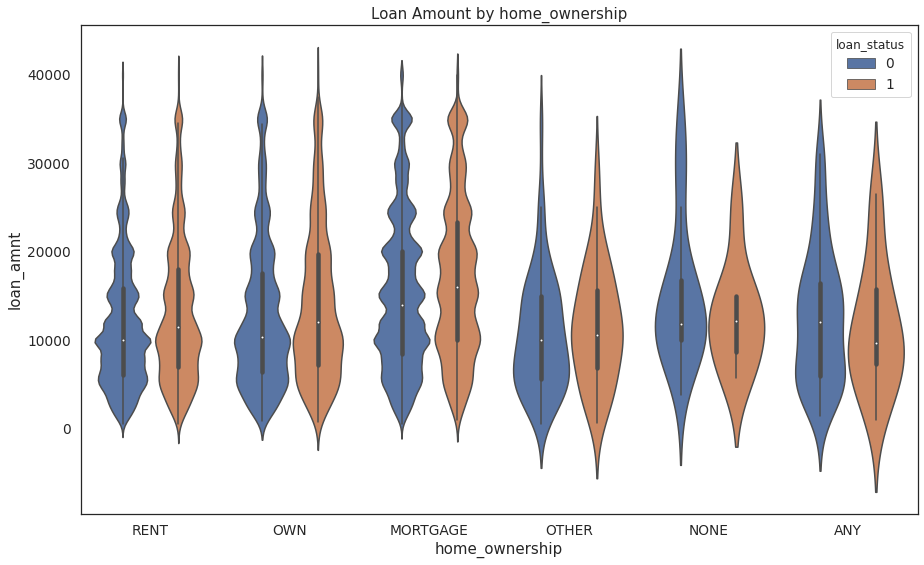

In [ ]:
fig, ax1=plt.subplots()
fig.set_size_inches(15,9)

ax1 = sns.violinplot(x=data_selected['home_ownership'], y=data_selected['loan_amnt'],data=data_selected, hue=data_selected['loan_status'])
ax1.set(xlabel ='home_ownership', ylabel='loan_amnt')
ax1.set_title('Loan Amount by home_ownership')

#RENT, OWN, MORTAGAGE has high distributed values, However the others do not have much variation. 

In [ ]:
#Further, dropping 'id' and 'state' columns before modeling 
data_selected.drop(['id', 'addr_state'], axis = 1, inplace= True) 

In [ ]:
#Up-Sampling the target variable
default_majority = data_selected[data_selected.loan_status==0]
default_minority=data_selected[data_selected.loan_status==1]
minority_upsampled = resample(default_minority,replace=True,n_samples=281764,random_state=45) 
minority_upsampled.shape[0]

281764

In [ ]:
data_sampled=pd.concat([default_majority,minority_upsampled])

In [ ]:
data_sampled.loan_status.value_counts()
data_selected=data_sampled.copy()
print(data_selected.loan_status.value_counts())

1    281764
0    281627
Name: loan_status, dtype: int64


In [ ]:
data_sampled

,loan_amnt,term,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,inq_last_6mths,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,total_rec_late_fee,recoveries,last_pymnt_amnt,last_fico_range_high,collections_12_mths_ex_med,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,hardship_flag,debt_settlement_flag
0,5000,36 months,10+ years,RENT,24000.0,Verified,0,n,credit_card,0.002765,0.0,735,1.0,0.0,13648,9.0,f,0.0,0.00,0.00,171.62,714,0.0,Individual,0.0,0.0,0.0,N,N
2,2400,36 months,10+ years,RENT,12252.0,Not Verified,0,n,small_business,0.000872,0.0,735,2.0,0.0,2956,10.0,f,0.0,0.00,0.00,649.91,739,0.0,Individual,0.0,0.0,0.0,N,N
3,10000,36 months,10+ years,RENT,49200.0,Source Verified,0,n,other,0.002000,0.0,690,1.0,0.0,5598,37.0,f,0.0,16.97,0.00,357.48,604,0.0,Individual,0.0,0.0,0.0,N,N
4,3000,60 months,1 year,RENT,80000.0,Source Verified,0,n,other,0.001794,0.0,695,0.0,0.0,27783,38.0,f,0.0,0.00,0.00,67.30,684,0.0,Individual,0.0,0.0,0.0,N,N
5,5000,36 months,3 years,RENT,36000.0,Source Verified,0,n,wedding,0.001120,0.0,730,3.0,0.0,7963,12.0,f,0.0,0.00,0.00,161.03,564,0.0,Individual,0.0,0.0,0.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268925,10925,36 months,10+ years,RENT,62000.0,Verified,1,n,credit_card,0.001105,0.0,665,0.0,0.0,4143,14.0,w,0.0,0.00,0.00,378.67,504,0.0,Individual,0.0,0.0,0.0,N,N
130816,24925,60 months,2 years,RENT,73000.0,Verified,1,n,debt_consolidation,0.002902,0.0,670,1.0,0.0,20058,23.0,f,0.0,0.00,7.92,681.20,564,0.0,Individual,0.0,0.0,0.0,N,N
326758,10000,36 months,3 years,RENT,45600.0,Not Verified,1,n,debt_consolidation,0.000334,0.0,680,0.0,1.0,4173,10.0,w,0.0,0.00,0.00,335.93,514,0.0,Individual,0.0,0.0,0.0,N,Y
311627,34250,36 months,3 years,OWN,185000.0,Source Verified,1,n,debt_consolidation,0.002572,0.0,700,0.0,0.0,8821,25.0,w,0.0,57.49,2164.40,432.88,544,0.0,Individual,0.0,0.0,0.0,N,Y


In [ ]:
data_selected['emp_length'] = data_selected['emp_length'].fillna(0)# Here we are just filling the NaN values with 0's but not deleting such records


In [ ]:
#Creating dummy variables to all the categorical variables
data_selected = pd.get_dummies(data_selected, columns=['term', 'emp_length', 'home_ownership', 
'verification_status', 'pymnt_plan', 'purpose', 'initial_list_status', 
'application_type', 'hardship_flag', 'debt_settlement_flag'])

In [ ]:
data_selected

,loan_amnt,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,inq_last_6mths,pub_rec,revol_bal,total_acc,out_prncp,total_rec_late_fee,recoveries,last_pymnt_amnt,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,term_ 36 months,term_ 60 months,emp_length_0,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,pymnt_plan_y,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,hardship_flag_Y,debt_settlement_flag_N,debt_settlement_flag_Y
0,5000,24000.0,0,0.002765,0.0,735,1.0,0.0,13648,9.0,0.0,0.00,0.00,171.62,714,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
2,2400,12252.0,0,0.000872,0.0,735,2.0,0.0,2956,10.0,0.0,0.00,0.00,649.91,739,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0
3,10000,49200.0,0,0.002000,0.0,690,1.0,0.0,5598,37.0,0.0,16.97,0.00,357.48,604,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0
4,3000,80000.0,0,0.001794,0.0,695,0.0,0.0,27783,38.0,0.0,0.00,0.00,67.30,684,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0
5,5000,36000.0,0,0.001120,0.0,730,3.0,0.0,7963,12.0,0.0,0.00,0.00,161.03,564,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268925,10925,62000.0,1,0.001105,0.0,665,0.0,0.0,4143,14.0,0.0,0.00,0.00,378.67,504,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0
130816,24925,73000.0,1,0.002902,0.0,670,1.0,0.0,20058,23.0,0.0,0.00,7.92,681.20,564,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
326758,10000,45600.0,1,0.000334,0.0,680,0.0,1.0,4173,10.0,0.0,0.00,0.00,335.93,514,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1
311627,34250,185000.0,1,0.002572,0.0,700,0.0,0.0,8821,25.0,0.0,57.49,2164.40,432.88,544,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1


In [ ]:
#Dropping one variable from each category to avoid dummy trap
data_selected.drop(['emp_length_7 years','verification_status_Verified', 'term_ 60 months', 'home_ownership_ANY' , 'pymnt_plan_y','purpose_car',
                    'initial_list_status_w', 'application_type_Joint App' , 'hardship_flag_Y', 'debt_settlement_flag_N'], axis=1, inplace = True)



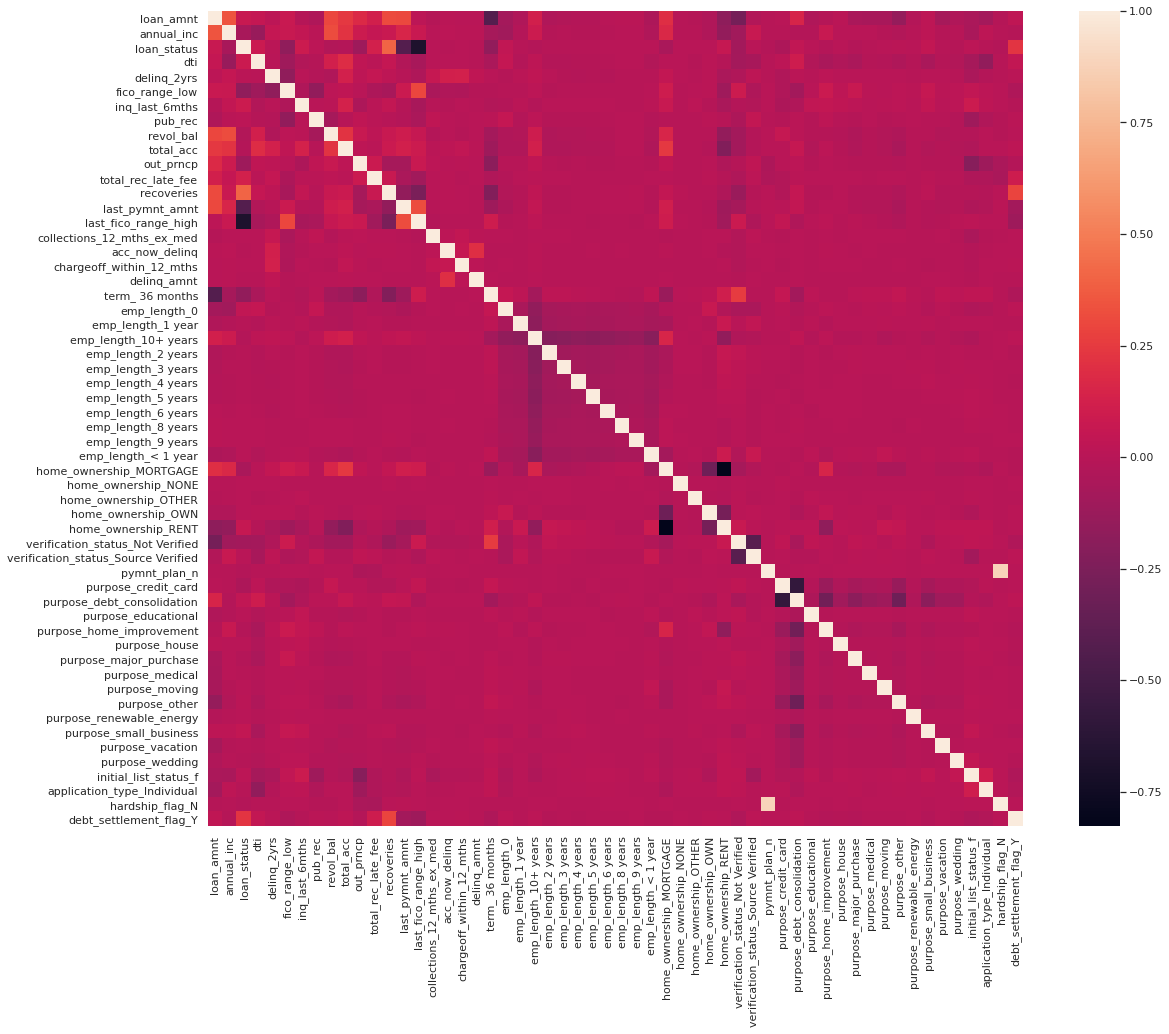

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
cor = data_selected.corr() 
plt.subplots(figsize=(20,15))
sns.heatmap(cor, square = True)

#We can see payment_plan_n and hardship_flag_N correlated. Hence getting rid of the later ones. 


In [ ]:
data_selected.drop(['hardship_flag_N'], axis=1, inplace = True) #removing the 'hardship_flag_N' as it shows correlation with 'payment_plan_n'

### Final DataFrame & Pickling 

In [ ]:
## Please note that we have used 'pickle' feature to save the dataframe created and use it in a distributed environment for modeling.(different workbooks) 
import pickle

data_selected.to_pickle("/content/drive/My Drive/Projects/Dipyaman Project/data_selected.pkl")

#data_selected = pd.read_pickle("/content/drive/My Drive/Projects/Dipyaman Project/data_selected.pkl")

## #Modeling and Algorithm Selection

##1- Logistics Regression

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_selected.drop("loan_status", axis=1), data_selected['loan_status'], test_size = 0.2,\
random_state=44)

In [ ]:
X_test.shape 

(112679, 54)

In [ ]:
logit = LogisticRegression()

In [ ]:
logit.fit(X_train, Y_train) 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Y_Pred=logit.predict(X_test) 

In [ ]:
logit.score(X_test, Y_test)

0.9255140709448966

In [ ]:
probs = logit.predict_proba(X_test)[::,1]

In [ ]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(Y_test, Y_Pred)
cnf_matrix

array([[53045,  3360],
       [ 5033, 51241]])

In [ ]:
precision_score=metrics.precision_score(Y_test, Y_Pred)
recall_score=metrics.recall_score(Y_test, Y_Pred)
accuracy_score=metrics.accuracy_score(Y_test, Y_Pred)
f1_score=metrics.f1_score(Y_test, Y_Pred)

print("precision_score", precision_score,
      "\nrecall_score", recall_score,
      "\naccuracy_score", accuracy_score,
      "\nf1_score", f1_score,
      "\nAUC" , roc_auc_score(Y_test, probs))

precision_score 0.9384626655189465 
recall_score 0.9105626043999004 
accuracy_score 0.9255140709448966 
f1_score 0.9243021420518601 
AUC 0.9818118254120743


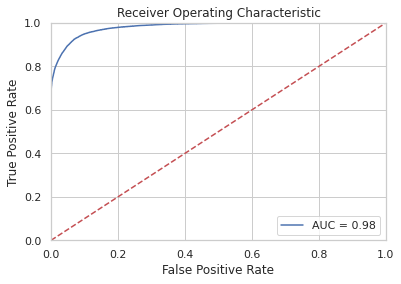

In [ ]:
fpr, tpr, threshold = roc_curve(Y_test, probs)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Decision Tree

##2- Decision Tree Algorithm 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_selected.drop("loan_status", axis=1), data_selected['loan_status'], test_size = 0.2,\
random_state=44)

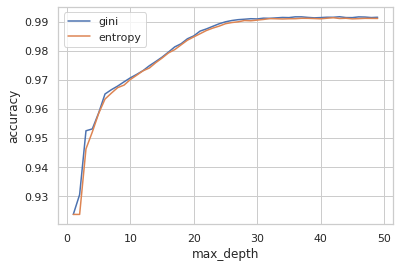

In [ ]:
#This piece of code is to check how accuracy varies by increasing tree depth. This will help us pick max_depth hyperparameter. 
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,50):
 dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
 dtree.fit(X_train, Y_train)
 pred = dtree.predict(X_test)
 acc_gini.append(accuracy_score(Y_test, pred))
 ####
 dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
 dtree.fit(X_train, Y_train)
 pred = dtree.predict(X_test)
 acc_entropy.append(accuracy_score(Y_test, pred))
 ####
 max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

We've considered two Hyperparameters in tuning the algorithm: 


1.   max_depth: This value is calculated from the above graph.
2.   max_features: We've employeed GridSearch method to find optimal max_features values. You can find its calculation in the next section: 'Using GridSearch for max_features'




In [ ]:
 
Based on the above calculations, considering max_depth=26
tree = DecisionTreeClassifier(max_depth= 26, max_features=13)

In [ ]:
tree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=26, max_features=13, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
pd.Series(tree.feature_importances_, index=X_train.columns).sort_values(ascending = False)

recoveries                             0.564893
last_fico_range_high                   0.226953
last_pymnt_amnt                        0.063410
dti                                    0.017571
fico_range_low                         0.015057
total_rec_late_fee                     0.013412
out_prncp                              0.013198
initial_list_status_f                  0.012485
loan_amnt                              0.010107
revol_bal                              0.008737
annual_inc                             0.008553
debt_settlement_flag_Y                 0.008545
total_acc                              0.007273
term_ 36 months                        0.003085
inq_last_6mths                         0.003027
pub_rec                                0.002066
verification_status_Not Verified       0.002035
emp_length_0                           0.001919
delinq_2yrs                            0.001713
verification_status_Source Verified    0.001511
home_ownership_RENT                    0

Considering the feature importance weights calculated above, its very interesting to note the following as Top 6 influencing parameters:  
1. recoveries                            
2. last_fico_range_high                   
3. last_pymnt_amnt                        
4. initial_list_status_f                  
5. out_prncp                              
6. loan_amnt 

In [ ]:
predictions = tree.predict(X_test)

In [ ]:
predictions[:5]

array([1, 0, 0, 0, 1])

In [ ]:
Y_test[:5]

299373    1
210352    0
45694     0
304084    0
55540     1
Name: loan_status, dtype: int64

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
accuracy_score(Y_test, predictions)

0.9888266669033271

In [ ]:
accuracy_score(Y_test, predictions, normalize=False)

111420

In [ ]:
confusion_matrix = confusion_matrix(Y_test, predictions)
confusion_df = pd.DataFrame(confusion_matrix, index=['Predicted Non-Defaulters','Predicted Defaulters'],\
                            columns=['Actual Non-Defaulters','Actual Defaulters'])

In [ ]:
confusion_df

,Actual Non-Defaulters,Actual Defaulters
Predicted Non-Defaulters,55277,1128
Predicted Defaulters,131,56143


Understanding the Confusion Matrix:

1. 55277 users have been predicted correctly who have Not Defaulted in Real
2. 56143 users have been predicted correctly who have Defaulted in Real
3. 131 users have been predicted as Defaulters, However in real they have Not Defaulted
4. 1128 users have been predicted as Non-Defaulters, However in real they have Defaulted

For the company(LC), the value 1128 stands to be very important, as it might cost heavy if not considered as they might default in real.

In [ ]:
precision_score=metrics.precision_score(Y_test, predictions)
recall_score=metrics.recall_score(Y_test, predictions)
accuracy_score=metrics.accuracy_score(Y_test, predictions)
f1_score=metrics.f1_score(Y_test, predictions)

print("precision_score", precision_score,
      "\nrecall_score", recall_score,
      "\naccuracy_score", accuracy_score,
      "\nf1_score", f1_score,
      "\nAUC" , roc_auc_score(Y_test, predictions))

precision_score 0.9803041679034764 
recall_score 0.9976721043465899 
accuracy_score 0.9888266669033271 
f1_score 0.9889118851556651 
AUC 0.9888369386195319


### Using GridSearch for 'max_features' 

In [ ]:
param_grid = [{"max_depth":[8,9,10,11,12,13,None], "max_features":[11,12,13,14,15,16,17]}]

In [ ]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=44),\
                 param_grid = param_grid,\
                 cv=10)

In [ ]:
gs.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=44,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [8, 9, 10, 11, 12, 13, None],
          

In [ ]:
gs.cv_results_['params']
gs.best_params_

{'max_depth': None, 'max_features': 13}

In [ ]:
predictions_new = gs.predict(X_test)

In [ ]:
confusion_matrix = confusion_matrix(Y_test, predictions_new)
confusion_df = pd.DataFrame(confusion_matrix, index=['Predicted Non-Defaulters','Predicted Defaulters'],\
                            columns=['Actual Non-Defaulters','Actual Defaulters'])
confusion_df

,Actual Non-Defaulters,Actual Defaulters
Predicted Non-Defaulters,55432,973
Predicted Defaulters,59,56215


In [ ]:
precision_score=metrics.precision_score(Y_test, predictions_new)
recall_score=metrics.recall_score(Y_test, predictions_new)
accuracy_score=metrics.accuracy_score(Y_test, predictions_new)
f1_score=metrics.f1_score(Y_test, predictions_new)

print("precision_score", precision_score,
      "\nrecall_score", recall_score,
      "\naccuracy_score", accuracy_score,
      "\nf1_score", f1_score)

# Please note that these values are when the max_depth is infinite. However, in the earlier section we've considered max_depth as 26 and max_features as 13. 

precision_score 0.9829859411065258 
recall_score 0.9989515584461741 
accuracy_score 0.990841239272624 
f1_score 0.9909044437785338


##3- Random Forest Algorithm

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier(max_depth=26)

In [ ]:
rf_model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=26, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
predictions_rf = rf_model.predict(X_test)

In [ ]:
precision_score=metrics.precision_score(Y_test, predictions_rf)
recall_score=metrics.recall_score(Y_test, predictions_rf)
accuracy_score=metrics.accuracy_score(Y_test, predictions_rf)
f1_score=metrics.f1_score(Y_test, predictions_rf)

print("precision_score", precision_score,
      "\nrecall_score", recall_score,
      "\naccuracy_score", accuracy_score,
      "\nf1_score", f1_score)

precision_score 0.9925298013245033 
recall_score 0.9987205459004158 
accuracy_score 0.9956069897673924 
f1_score 0.9956155501820211


##4- SVM

In [ ]:
#Please consider not running this cell as it takes a lot of processing time. 
#svc = SVC(random_state=42)
svc.fit(X_train, Y_train)

In [ ]:
Y_pred = svc.predict(X_test)
confusion_matrix(Y_test, Y_pred)

array([[56170,   351],
       [20406, 35762]])

In [ ]:
precision_score=metrics.precision_score(Y_test, Y_pred)
recall_score=metrics.recall_score(Y_test, Y_pred)
accuracy_score=metrics.accuracy_score(Y_test, Y_pred)
f1_score=metrics.f1_score(Y_test, Y_pred)

print("precision_score", precision_score,
      "\nrecall_score", recall_score,
      "\naccuracy_score", accuracy_score,
      "\nf1_score", f1_score)

precision_score 0.9902805084041758 
recall_score 0.6366970517020367 
accuracy_score 0.8158027846551127 
f1_score 0.7750674570063175


##5- Single Layered ANN

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_selected.drop("loan_status", axis=1), data_selected['loan_status'], test_size = 0.2,\
random_state=44)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Phase 2: Making the Neural Network (NN)

# Importing the Keras libraries and packages


In [ ]:
# Initialising the ANN
Defaulter_predictor = Sequential() 

In [ ]:
# Adding the input layer and the hidden layer
Defaulter_predictor.add(Dense(input_dim=54, activation="relu", kernel_initializer="uniform", units=15))

In [ ]:
# Adding the output layer
Defaulter_predictor.add(Dense(activation = 'sigmoid', kernel_initializer = "uniform", units = 1))

In [ ]:
Defaulter_predictor.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Fitting the ANN to the Training set
Defaulter_predictor.fit(X_train, Y_train, batch_size = 10, nb_epoch = 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/100
450712/450712 [==============================] - 48s 106us/step - loss: 0.1757 - accuracy: 0.9237
Epoch 2/100
450712/450712 [==============================] - 48s 106us/step - loss: 0.1608 - accuracy: 0.9293
Epoch 3/100
450712/450712 [==============================] - 49s 108us/step - loss: 0.1577 - accuracy: 0.9304
Epoch 4/100
450712/450712 [==============================] - 48s 106us/step - loss: 0.1555 - accuracy: 0.9310
Epoch 5/100
450712/450712 [==============================] - 48s 107us/step - loss: 0.1543 - accuracy: 0.9317
Epoch 6/100
450712/450712 [==============================] - 48s 107us/step - loss: 0.1531 - accuracy: 0.9321
Epoch 7/100
450712/450712 [==============================] - 48s 107us/step - loss: 0.1523 - accuracy: 0.9325
Epoch 8/100
450712/450712 [==============================] - 48s 107us/step - loss: 0.1514 - accuracy: 0.9327
Epoch 9/100
450712/450712 [==============================] - 48s 106us/step - loss: 0.1508 - accuracy: 0.9330
Epoch 10/1

In [ ]:
Y_pred = Defaulter_predictor.predict(X_test)
# this gives us the probability of a patient having diabetes

In [ ]:

Y_pred = (Y_pred > 0.5)

In [ ]:
conf_mat = confusion_matrix(Y_test, Y_pred)

conf_mat

array([[53224,  3181],
       [ 3258, 53016]])

In [ ]:
#Accuracy: 
(53224 + 53016 )/ ( 53224 + 53016+ 3181 + 3258)

0.9428553679035135

Please note that the loss values are continuesly decreasing while increasing the epochs. Hence, the model doesn't seem to be overfitting. Hence early stoppings and dropouts are not necessary. 

##6- Multilayered ANN

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_selected.drop("loan_status", axis=1), data_selected['loan_status'], test_size = 0.2,\
random_state=44)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Phase 2: Making the Neural Network (NN)

# Importing the Keras libraries and packages


In [ ]:
# Initialising the ANN
Defaulter_predictor = Sequential() 

In [ ]:
# Adding the input layer and the hidden layer
Defaulter_predictor.add(Dense(input_dim=54, activation="relu", kernel_initializer="uniform", units=15))

In [ ]:
# Adding the second hidden layer
Defaulter_predictor.add(Dense(activation = "relu", kernel_initializer = "uniform", units = 15))

In [ ]:
# Adding the output layer
Defaulter_predictor.add(Dense(activation = 'sigmoid', kernel_initializer = "uniform", units = 1))

In [ ]:
Defaulter_predictor.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
Defaulter_predictor.fit(X_train, Y_train, batch_size = 10, nb_epoch = 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/100
450712/450712 [==============================] - 48s 108us/step - loss: 0.1757 - accuracy: 0.9233
Epoch 2/100
450712/450712 [==============================] - 48s 107us/step - loss: 0.1624 - accuracy: 0.9286
Epoch 3/100
450712/450712 [==============================] - 49s 108us/step - loss: 0.1586 - accuracy: 0.9304
Epoch 4/100
450712/450712 [==============================] - 49s 109us/step - loss: 0.1563 - accuracy: 0.9314
Epoch 5/100
450712/450712 [==============================] - 49s 108us/step - loss: 0.1536 - accuracy: 0.9324
Epoch 6/100
450712/450712 [==============================] - 48s 107us/step - loss: 0.1514 - accuracy: 0.9332
Epoch 7/100
450712/450712 [==============================] - 51s 113us/step - loss: 0.1497 - accuracy: 0.9338
Epoch 8/100
450712/450712 [==============================] - 49s 108us/step - loss: 0.1485 - accuracy: 0.9343
Epoch 9/100
450712/450712 [==============================] - 49s 108us/step - loss: 0.1475 - accuracy: 0.9347
Epoch 10/1

In [ ]:
Y_pred = Defaulter_predictor.predict(X_test)

In [ ]:
Y_pred = (Y_pred > 0.5)

In [ ]:
conf_mat = confusion_matrix(Y_test, Y_pred)

conf_mat

array([[53384,  3021],
       [ 3108, 53166]])

In [ ]:
#Accuracy 
(53384 + 53166 )/ ( 53384 + 53166+ 3021 + 3108)

0.945606546028985

Please note that the loss values are continuesly decreasing while increasing the epochs. Hence, the model doesn't seem to be overfitting. Hence early stoppings and dropouts are not necessary.

##7- Ensemble learning

###a- Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_selected_dummy, data_selected['loan_status'], test_size = 0.2,\
random_state=44)

In [ ]:
gbclf = GradientBoostingClassifier().fit(X_train, Y_train)

In [ ]:
y_pred = gbclf.predict(X_test)

In [ ]:
GB_accuracy=accuracy_score(Y_test, y_pred)
GB_accuracy #Accuracy 

0.9687130998357526

In [ ]:
scores2 = cross_val_score(gbclf,X_train, Y_train, cv=5)
scores2

array([0.96954765, 0.96870422, 0.96954765, 0.96883705, 0.9691256 ])

In [ ]:
print("validation score: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

validation score: 0.97 (+/- 0.00)


###b- Bagging Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
bag_clf = BaggingClassifier().fit(X_train, Y_train)

In [ ]:
y_pred = bag_clf.predict(X_test)

In [ ]:
Bagging_accu=accuracy_score(Y_test, y_pred)
Bagging_accu #Accuracy

0.9947352066409197

In [ ]:
scores2 = cross_val_score(bag_clf,X_train,Y_train , cv=5)
scores2

array([0.99252009, 0.99290851, 0.99290851, 0.99273086, 0.99323027])

In [ ]:
print("validation score: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

validation score: 0.99 (+/- 0.00)


###c- Bagging Classifier with Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

In [ ]:
bagged_model=BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)

In [ ]:
bagged_model.fit(X_train, Y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [ ]:
predictions = bagged_model.predict(X_test)

In [ ]:
Bag_tree_accu=accuracy_score(Y_test, predictions)
Bag_tree_accu #Accuracy

0.9501753451413859

###d- Voting Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

In [ ]:
log_model3 = LogisticRegression()
dtree_model3 = DecisionTreeClassifier()
rf_model = RandomForestClassifier()

ensemble3 = VotingClassifier(estimators=[('lr', log_model3), ('dtree', dtree_model3),('rf',rf_model)], voting='hard')
ensemble3.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('dtree',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gin...
                                        

In [ ]:
for model in (log_model3, dtree_model3,rf_model, ensemble3):
    model.fit(X_train, Y_train)
    predictions3 = model.predict(X_test)
    print(model.__class__.__name__, accuracy_score(Y_test, predictions3))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression 0.9256915663078302
DecisionTreeClassifier 1.0
RandomForestClassifier 1.0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


VotingClassifier 1.0


###e- AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
ada_model2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=200, learning_rate=0.48, random_state=44)
ada_model2.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
print("Accuracy:", accuracy_score(Y_test_e3, predictions)) #Accuracy

Accuracy: 0.9938473831402317


### f- Extra Tree Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
Extra_model = ExtraTreesClassifier(n_estimators=500, n_jobs=-1)

In [ ]:
Extra_model.fit(X_train, Y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [ ]:
predictions = Extra_model.predict(X_test)

In [ ]:
Ext_tree_accu=accuracy_score(Y_test, predictions)
Ext_tree_accu #Accuracy

0.995463221911484

In [ ]:
scores2 = cross_val_score(Extra_model,X_train, Y_train , cv=5)
scores2

array([0.99207618, 0.99192081, 0.99225374, 0.99237573, 0.99194291])

# ***PART II: Natural Language Processing (NLP)***

In [ ]:
#Freshly reading the data into 'data' dataframe
data = pd.read_csv("/content/drive/My Drive/Projects/Dipyaman Project/fullacc.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,49,59,129,130,131,134,135,136,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data_nlp = data[['id', 'loan_status', 'desc']].copy() #selecting only required fields for NLP Analysis

In [ ]:
data_nlp.dropna(subset=['desc'], inplace=True) #Dropping all unavailable 'desc' records


In [ ]:
data_nlp # Please observe the uncleaned 'desc' field. 

,id,loan_status,desc
0,1077501,0,Borrower added on 12/22/11 > I need to upgra...
1,1077430,1,Borrower added on 12/22/11 > I plan to use t...
3,1076863,0,Borrower added on 12/21/11 > to pay for prop...
4,1075358,0,Borrower added on 12/21/11 > I plan on combi...
6,1069639,0,Borrower added on 12/18/11 > I am planning o...
...,...,...,...
230710,1062337,0,Borrower added on 12/11/11 > pay off credit ...
230711,1062400,0,Borrower added on 12/08/11 > I will be payin...
230714,1058722,1,Borrower added on 12/06/11 > need to pay off...
230715,1058291,0,Borrower added on 12/06/11 > Want to close d...


## Data Pre-Processing

### 1- Regular Expressions


In [ ]:
k=0
desc_list=[]
for line in data_nlp.desc:  
  text = re.sub('<.*?>', '',line) #This expression removes the <br> which is found at the end of every sentence
  desc_list.append(re.sub('Borrower added on \d{2}/\d{2}/\d{2} >', '', text)) # This removes the date/year in every sentence
  k=k+1
data_nlp['desc_cleaned'] = desc_list

In [ ]:
data_nlp

,id,loan_status,desc,desc_cleaned
0,1077501,0,Borrower added on 12/22/11 > I need to upgra...,I need to upgrade my business technologies.
1,1077430,1,Borrower added on 12/22/11 > I plan to use t...,I plan to use this money to finance the mot...
3,1076863,0,Borrower added on 12/21/11 > to pay for prop...,to pay for property tax (borrow from friend...
4,1075358,0,Borrower added on 12/21/11 > I plan on combi...,I plan on combining three large interest bi...
6,1069639,0,Borrower added on 12/18/11 > I am planning o...,I am planning on using the funds to pay off...
...,...,...,...,...
230710,1062337,0,Borrower added on 12/11/11 > pay off credit ...,pay off credit cards faster with a lower in...
230711,1062400,0,Borrower added on 12/08/11 > I will be payin...,I will be paying off three credit card bala...
230714,1058722,1,Borrower added on 12/06/11 > need to pay off...,"need to pay off my truck note, other expens..."
230715,1058291,0,Borrower added on 12/06/11 > Want to close d...,Want to close down credit cards and pay the...


### 2- Tokenizing, Lemmatizing, Stopwords treatment

In [ ]:
from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords
import nltk
from nltk.corpus import stopwords  
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 
from nltk.stem import WordNetLemmatizer 
  
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
## Tokenising, Lemmatising and then removing the stop words. 
k = 0
filtered_sentence = [] 
final_sentence=[]
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

for line in data_nlp.desc_cleaned:
  line=lemmatizer.lemmatize(line) 
  word_tokens = word_tokenize(line)
  filtered_sentence = [] 
  for w in word_tokens: 
    if w.isalnum(): #considering only Alpha-numberic charachters 
      if w not in stop_words: 
        filtered_sentence.append(w)
      
  final_sentence.append(' '.join(filtered_sentence))
  
data_nlp['desc_cleaned'] = final_sentence




###3 -Rejecting most Common Words

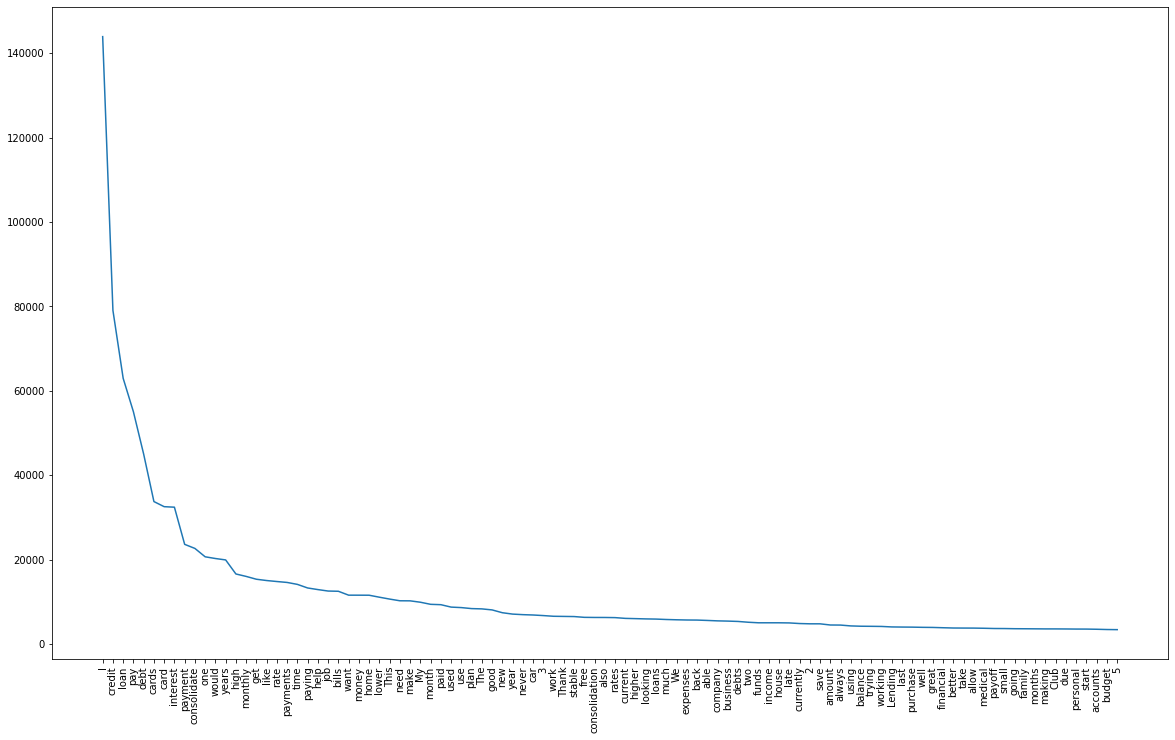

[('I', 143908), ('credit', 79035), ('loan', 62934), ('pay', 55011), ('debt', 44971), ('cards', 33736), ('card', 32525), ('interest', 32404), ('payment', 23599), ('consolidate', 22630), ('one', 20648), ('would', 20242), ('years', 19906), ('high', 16578), ('monthly', 16000), ('get', 15330), ('like', 15023), ('rate', 14788), ('payments', 14570), ('time', 14112), ('paying', 13261), ('help', 12879), ('job', 12533), ('bills', 12479), ('want', 11556), ('money', 11552), ('home', 11542), ('lower', 11074), ('This', 10630), ('need', 10227), ('make', 10211), ('My', 9884), ('month', 9386), ('paid', 9300), ('used', 8728), ('use', 8611), ('plan', 8374), ('The', 8305), ('good', 8062), ('new', 7396)]


In [ ]:
## Checking the most frequent and least occouring words and removing them. 
temp=[]
for line in data_nlp.desc_cleaned:
  temp.append(''.join(line))
  #BOW.append(' '.join(line))
#BOW=''.join(BOW)
temp=str(temp).split()

k=0
BOW=[]
while k<len(temp):
  if temp[k].isalnum():
    BOW.append(''.join(temp[k]))
  k=k+1



from collections import Counter
diction = Counter(BOW).most_common(100)

import matplotlib.pylab as plt

lists = sorted(diction) # sorted by key, return a list of tuples
plt.subplots(figsize=(20,12))
x, y = zip(*diction) # unpack a list of pairs into two tuples
plt.xticks(rotation=90)
plt.plot(x, y)
plt.show()

print(Counter(BOW).most_common(40))
### Based on the below graph, we will be removing the top repeating words till 'good' 
remove_list=[]
i=0
remove_dict= Counter(BOW).most_common(39)
while i < 39: 
  remove_list.append(remove_dict[i][0])
  i=i+1

#

In [ ]:
remove_list

['I',
 'credit',
 'loan',
 'pay',
 'debt',
 'cards',
 'card',
 'interest',
 'payment',
 'consolidate',
 'one',
 'would',
 'years',
 'high',
 'monthly',
 'get',
 'like',
 'rate',
 'payments',
 'time',
 'paying',
 'help',
 'job',
 'bills',
 'want',
 'money',
 'home',
 'lower',
 'This',
 'need',
 'make',
 'My',
 'month',
 'paid',
 'used',
 'use',
 'plan',
 'The',
 'good']

In [ ]:
### Removing the most occouring words from remove_list and rebuilding the 'desc_cleaned' column:

filtered_sentence = [] 
final_sentence=[]

for line in data_nlp.desc_cleaned:
  word_tokens = word_tokenize(line)
  filtered_sentence = [] 
  for w in word_tokens: 
    if w.isalnum(): 
      if w not in remove_list: 
        filtered_sentence.append(w)
      
  final_sentence.append(' '.join(filtered_sentence))
  
data_nlp['desc_cleaned'] = final_sentence


In [ ]:
data_nlp

,id,loan_status,desc,desc_cleaned
0,1077501,0,Borrower added on 12/22/11 > I need to upgra...,upgrade business technologies
1,1077430,1,Borrower added on 12/22/11 > I plan to use t...,finance motorcycle looking soon sell old bike ...
3,1076863,0,Borrower added on 12/21/11 > to pay for prop...,property tax borrow friend back central replac...
4,1075358,0,Borrower added on 12/21/11 > I plan on combi...,combining three large together freeing extra t...
6,1069639,0,Borrower added on 12/18/11 > I am planning o...,planning using funds two retail rates well maj...
...,...,...,...,...
230710,1062337,0,Borrower added on 12/11/11 > pay off credit ...,faster never missed late secure
230711,1062400,0,Borrower added on 12/08/11 > I will be payin...,three balances business several always debit a...
230714,1058722,1,Borrower added on 12/06/11 > need to pay off...,truck note expenses happy offer personal loans
230715,1058291,0,Borrower added on 12/06/11 > Want to close d...,Want close way alot easier magagement


## 1- Naive Bayes - CountVect

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1))

In [ ]:
text_counts= cv.fit_transform(data_nlp['desc_cleaned'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, data_nlp['loan_status'], test_size=0.3, random_state=45)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.8250293524400156


##2- Naive Bayes - TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
text_tf= tf.fit_transform(data_nlp['desc_cleaned'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, data_nlp['loan_status'], test_size=0.2, random_state=45)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.8406412282682321


##3- Single Layered ANN

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
text_tf= tf.fit_transform(data_nlp['desc_cleaned'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, data_nlp['loan_status'], test_size=0.2, random_state=45)

In [ ]:
from keras.models import Sequential
from keras import layers


In [ ]:
input_dim = X_train.shape[1]

In [ ]:
model = Sequential()
model.add(Dense(input_dim=input_dim, activation="relu", kernel_initializer="uniform", units=15))
model.add(Dense(activation = 'sigmoid', kernel_initializer = "uniform", units = 1))

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size = 10, nb_epoch = 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/100
88576/88576 [==============================] - 64s 724us/step - loss: 0.4305 - accuracy: 0.8454
Epoch 2/100
88576/88576 [==============================] - 64s 728us/step - loss: 0.4128 - accuracy: 0.8455
Epoch 3/100
88576/88576 [==============================] - 64s 724us/step - loss: 0.4041 - accuracy: 0.8455
Epoch 4/100
88576/88576 [==============================] - 64s 726us/step - loss: 0.3981 - accuracy: 0.8455
Epoch 5/100
88576/88576 [==============================] - 65s 732us/step - loss: 0.3930 - accuracy: 0.8457
Epoch 6/100
88576/88576 [==============================] - 64s 724us/step - loss: 0.3888 - accuracy: 0.8461
Epoch 7/100
88576/88576 [==============================] - 65s 734us/step - loss: 0.3850 - accuracy: 0.8465
Epoch 8/100
88576/88576 [==============================] - 68s 763us/step - loss: 0.3814 - accuracy: 0.8476
Epoch 9/100
88576/88576 [==============================] - 66s 742us/step - loss: 0.3781 - accuracy: 0.8512
Epoch 10/100
88576/88576 [==

Therefore, can be said that we could predict the 'Default' values 94.2% accurately with description column. 

# Conclusion

While we have tried different methods to predict the default, one of the major observation lies on the factors(predictors) that drive people to default. 

As we have listed in "2- Decision Tree Algorithm" section, the Top 6 such parameters and why they are probably true: 
1. recoveries: While connecting the dots backwards, one can understand that the amount recovered after charging off categorises if a user has paid/ defaulted.        
2. last_fico_range_high: Certainly FICO are the most important parameter that indicates an individual's credit health. Insurance/Creditors spend a lot on this area to well qualify the credit limit to an individual.                
3. last_pymnt_amnt: Intuitively, someone who would be paying would show a sign of it by paying frequently. Hence, for sure this is an important predictor variable.                         
4. initial_list_status_f: Interesting to learn that LendingClub claims to have allocating fractional(f) and whole(w) randomly to their customers. However, a lot of claimed that its a scam! (https://forum.lendacademy.com/index.php?topic=4815.0). In general, whole accounts are considered to give great returns. Hence, this parameter might play an important role in defaulting (as this represent 'fractional')
5. out_prncp:Remaining outstanding principal for total amount funded. Certainly is an important factor.                              
6. loan_amnt: For an obvious reason! The loan amount taken plays important factor for someone to payback or not.


This important exercise helped us understand cleaning the data, looking for a right plot to tell the story encoded in data, understanding which predictors weigh less importance and getting rid of them, ofcourse modeling and hyperparameters tuning. 

Moreover, we could understand importance of NLP while predicting the defaults with just with a description column. "Now I get how can an experienced loan lender guage if someone would default just by listning the reason to the loan ('description')!"